<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment 


In [26]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature selection
from sklearn import feature_selection
# Univariate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import GenericUnivariateSelect
# Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from yellowbrick.datasets import load_concrete
from sklearn.feature_selection import SelectFromModel

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

## Data Loading

In [28]:
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

print(f'The number of rows of train data : {len(data_train.index)}')
print(f'The number of rows of test data : {len(data_test.index)}')

# dataframe containing tumor stadium of subject (T12/T34)
stage_train = data_train['label']             
stage_test = data_test['label'] 

# dataframe containing all feature columns except 'label' (tumor stadium of subject)
data_train = data_train.drop(columns='label') 
data_test = data_test.drop(columns='label')

# Binarize label data
stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
stage_train = [i[0] for i in stage_train]
stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
stage_test = [i[0] for i in stage_test]



The number of samples: 113
The number of columns: 160
The number of rows of train data : 90
The number of rows of test data : 23


## Data cleaning


In [29]:
# Imputation
#imp = SimpleImputer(missing_values=np.nan, strategy='median')
#imp.fit(data_train)
#data_train = imp.transform(data_train)
#data_test = imp.transform(data_test)

# Remove all columns where more than 25% of the values are 0.0
drop_cols_train = data_train.columns[(data_train == 0).sum() > 0.25*data_train.shape[1]]
drop_cols_test = data_test.columns[(data_train ==0).sum() > 0.25*data_train.shape[1]]
data_train.drop(drop_cols_train, axis = 1, inplace = True) 
data_test.drop(drop_cols_test, axis = 1, inplace = True)
print(f'The number of columns after preprocessing: {len(data_train.columns)}')
print(f'The number of columns after preprocessing: {len(data_test.columns)}')


# Remove all columns with no std
drop_std_train = data_train.columns[data_train.std() == 0]
drop_std_test = data_test.columns[data_train.std() == 0]
data_train.drop(drop_std_train, axis = 1, inplace = True) 
data_test.drop(drop_std_test, axis = 1, inplace = True)

print(f'TRAIN: The number of columns after preprocessing: {len(data_train.columns)}, and the number of rows: {len(data_train.index)}')
print(f'TEST: The number of columns after preprocessing: {len(data_test.columns)},  and the number of rows: {len(data_test.index)}')


The number of columns after preprocessing: 152
The number of columns after preprocessing: 152
TRAIN: The number of columns after preprocessing: 148, and the number of rows: 90
TEST: The number of columns after preprocessing: 148,  and the number of rows: 23


## Data Scaling


StandardScaler removes the mean and scales the data to unit variance.  cannot guarantee balanced feature scales in the presence of outliers.

MinMaxScaler rescales the data set such that all feature values are in the range [0, 1], very sensitive to outliers

Robust scaler. Unlike the previous scalers, the centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers.
 

In [0]:
# Scale the data (train on train set)
scaler = preprocessing.StandardScaler()   
scaler.fit(data_train)  

# Perform scaling on both train and testset
data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test) 

## Preprocessing: Feature selection/extraction

- Recursive Feature Elimination
- Univariate Feature Selection
- Principal Component Analysis
- L1/Lasso Regression Feature Selection

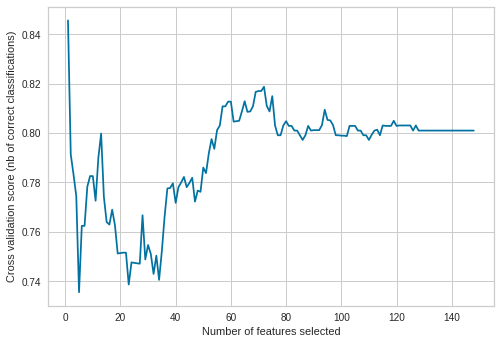

Num Features: 1
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Feature Ranking: [113  34   3  79 144 136 120   9   6 145  11  

In [31]:
# Recursive Feature Elimination
svc = svm.SVC(kernel="linear")  # Create the RFE object and compute a cross-validated score.

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit_rfecv = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit_rfecv.n_features_)
print("Selected Features: %s" % fit_rfecv.support_)
print("Feature Ranking: %s" % fit_rfecv.ranking_)

data_train_rfecv = rfecv.transform(data_train_scaled)
data_test_rfecv = rfecv.transform(data_test_scaled)

print(data_train_rfecv.shape)
print(data_test_rfecv.shape)

##  Feature selection using univariate feature selection

In [32]:
# Eventuele hyperparameters die nog kunnen worden aangepast: methodes voor univariate feature selection (selectKBest, SelectPercentile, en nog meer),
# measures om 'best' te bepalen chi2, f_classif, mutual_info_classif
# aantal features dat je selecteert, getal voor percentile, getal voor k-best, etc.
# Moeilijk om deze hyperparameters te tunen aangezien de performance pas wordt bepaald bij het toepassen van de classifier, zal waarschijnlijk ook verschillen per classifier.
# 
# Bij het opnieuw splitten van de data in een train en test set zie je dat er een andere set aan features geselecteerd wordt, zijn overeenkomsten maar je ziet ook verschillen. Zeer waarschijnlijk leidt dit uiteindelijk tot een hogere variantie in performance bij het nemen van een nieuwe split mbv cross validatie checken.

# Apply SelectPercentile to train data to extract top 20% best features according to train data
selector = SelectPercentile(f_classif, percentile=20)
fit_uni = selector.fit(data_train_scaled, stage_train)

# Visualisation of the selected best 20% features
dfscores = pd.DataFrame(fit_uni.scores_)
dfcolumns = pd.DataFrame(data_train.columns)
# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# Print dataframe
print(featureScores.nlargest(int(0.2*len(featureScores)),'Score'))  #print 40 best features

data_train_uni = selector.transform(data_train_scaled)
data_test_uni = selector.transform(data_test_scaled)

print(data_train_uni.shape)
print(data_test_uni.shape)

                                         Specs      Score
43                        tf_GLRLM_RunVariance  45.853711
39                         tf_GLRLM_RunEntropy  44.696051
35                    tf_GLRLM_LongRunEmphasis  43.179710
25                          sf_rad_dist_avg_2D  42.959173
32             tf_GLRLM_GrayLevelNonUniformity  42.782941
31                                sf_volume_2D  36.167098
42                      tf_GLRLM_RunPercentage  35.229111
0                                    hf_energy  29.953098
41   tf_GLRLM_RunLengthNonUniformityNormalized  29.029403
40             tf_GLRLM_RunLengthNonUniformity  28.486611
7                                      hf_peak  28.372317
36       tf_GLRLM_LongRunHighGrayLevelEmphasis  26.205712
26                          sf_rad_dist_std_2D  25.430879
44                   tf_GLRLM_ShortRunEmphasis  23.066558
128                       tf_Gabor_0.5A2.36max  22.476019
134                     tf_LBP_kurtosis_R3_P12  21.330221
51     tf_GLSZ

## Principal Component Analysis (PCA)


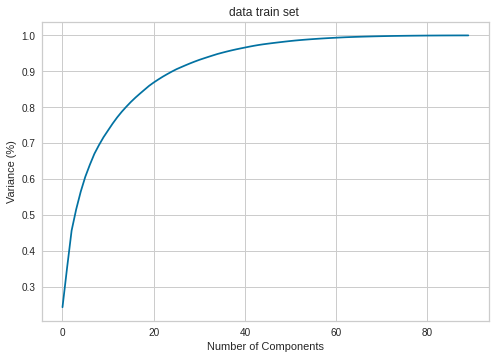

(90, 56)
(23, 56)


In [33]:

# Create a function for calculating PCA
def pca(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train_trans = pca_train.transform(data_train)
    data_test_trans = pca_train.transform(data_test)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') # for each component
    plt.title('data train set ')
    plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

    # Return transformed train- and testdata
    return data_train_trans, data_test_trans

data_train_pca, data_test_pca = pca(data_train_scaled, data_test_scaled)
print(data_train_pca.shape)
print(data_test_pca.shape)



## Lasso feature selection


The optimal alpha = 0.04818530062506049
Selected 16 from 148 features.


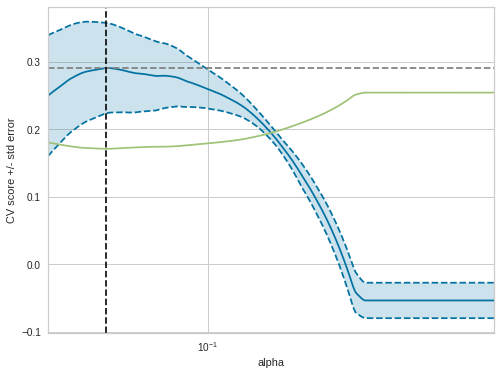

In [34]:
lasso = Lasso(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Lasso(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")



# Feature Selecions
The data framees from the feature selecions of  univariate, PCA and LASSO are combined. 

These can be used by the classifiers

In [0]:
data_train_fs = [data_train_uni, data_train_pca, data_train_l1] 
data_test_fs = [data_test_uni, data_test_pca, data_test_l1]   


# L2/ridge classifier

In [36]:
ridge = RidgeClassifier(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Ridge(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Ridge(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

NameError: ignored

## kNN


In [53]:
def knn_classifier(leaf_size, p, n_neigbors, weights, data_train, data_test, label_train, label_test):
    """
    Function for kNN training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    knn = neighbors.KNeighborsClassifier(leaf_size = leaf_size, weights = weights, n_neighbors = n_neigbors, p = p)
    knn.fit(data_train, label_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    score_train = knn.score(data_train, label_train)
    score_test = knn.score(data_test, label_test)
    return score_train, score_test, label_train_knn, label_test_knn


# Hyperparameters optimization 
leaf_size = list(range(1,50))
n_n = list(range(1,50))
p=[1,2]
weights = ['uniform', 'distance']

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n, p=p, weights = weights)
knn_tune = neighbors.KNeighborsClassifier()
clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=10)

# for loop for caluculation score and stage with the different feature selections
score_train_knn = []
score_test_knn = []
stage_train_knn = []
stage_test_knn = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model = clf_tune_knn.fit(df, stage_train)

    leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
    p_best = best_model.best_estimator_.get_params()['p']
    n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
    weights_best = best_model.best_estimator_.get_params()['weights']
   
    score_train_k, score_test_k, stage_train_k, stage_test_k = knn_classifier(leaf_size_best, 
                        p_best, n_n_best, weights_best, df, df_test, stage_train, stage_test)

    score_train_knn.append(score_train_k)
    score_test_knn.append(score_test_k)
    stage_train_knn.append(stage_train_k)
    stage_test_knn.append(stage_test_k)


# Printing accuracy and predicted stage
print(f'Accuracy of classifier on traindata: {score_train_knn}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_knn}') # accuracy
print(stage_train_knn)
print(' ')
print(stage_test_knn)





Accuracy of classifier on traindata: [0.7333333333333333, 1.0, 0.8444444444444444]
Accuracy of classifier on testdata: [0.6086956521739131, 0.6086956521739131, 0.7391304347826086]
[array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0]), array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0

## Support Vector Machine (SVM)
-  Geeft nu alleen een kernel mee, maar heeft nog veel meer parameters
- test_decision = svc.decision_function(data_test) kunnen we later miss nog gebruiken om een ROC te maken

In [41]:
def svm_classifier(C, kernel, degree, gamma, data_train, data_test, label_train, label_test, svm_kernel):
    """
    Function for SVM training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        svm_kernel = different kernels to be used (type = string)

    Output is two lists with the predicted class of the train- and testdata
    """
    svc = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    svc.fit(data_train, label_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)

    score_train = svc.score(data_train, label_train)
    score_test = svc.score(data_test, label_test)
    
    return score_train, score_test, label_train_svm, label_test_svm


# Hyperparameter optimization
kernels = ['linear', 'poly', 'rbf']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

hyperparameters = dict(kernel = kernels, gamma = gammas, C = cs, degree = degrees)
svm_tune = svm.SVC()
clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv=10)

# For loop 
score_train_svm = []
score_test_svm = []
stage_train_svm = []
stage_test_svm = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model_svm = clf_tune_svm.fit(df, stage_train)

    kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
    gamma_best = best_model_svm.best_estimator_.get_params()['gamma']
    c_best = best_model_svm.best_estimator_.get_params()['C']
    degree_best = best_model_svm.best_estimator_.get_params()['degree']
    
    score_train_s, score_test_s, stage_train_s, stage_test_s = svm_classifier(c_best, 
                  kernel_best, degree_best, gamma_best, df, df_test, 
                  stage_train, stage_test, 'linear')

    score_train_svm.append(score_train_s)
    score_test_svm.append(score_test_s)
    stage_train_svm.append(stage_train_s)
    stage_test_svm.append(stage_test_s)


# Printing accuracy and predicted stage
print(f'Accuracy of classifier on traindata: {score_train_svm}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_svm}') # accuracy
print(stage_train_svm)
print(' ')
print(stage_test_svm)



Accuracy of classifier on traindata: [0.7777777777777778, 0.9777777777777777, 0.8666666666666667]
Accuracy of classifier on testdata: [0.6521739130434783, 0.6956521739130435, 0.6956521739130435]
[array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1

## Random Forest Classifier 
- n_estomators: number of tress in forest, default is 10
- max_depth: maximum depth of tree 
- min_samples_split: minn number of samples required to split an internal node
- max_featrues: number of features consider when looking fot the best split 
- bootstrap
- class_weight  




In [43]:
def rfc_classifier(n_estimators, max_depth, min_samples_split, min_samples_leaf, 
                   bootstrap, class_weight, data_train, data_test, label_train, 
                   label_test):
    """
    Function for RFC training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create Random Forest Classifier and fit classifier on traindata
    rfc = RandomForestClassifier(n_estimators = n_estimators, max_depth = 
              max_depth, min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,
             class_weight = class_weight)
    rfc.fit(data_train, label_train)

    # Predict labels for train- and testdata
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    score_train = rfc.score(data_train, label_train)
    score_test = rfc.score(data_test, label_test)

    return score_train, score_test, label_train_rfc, label_test_rfc

# Hyperparameters optimization
n_estimators = [10, 30, 50, 100, 300]     
max_depth = [5, 10, 15, 20, 30]                
min_samples_split = [2, 7, 10, 12, 20]      
min_samples_leaf = [1, 5, 10, 15, 20]             
bootstrap = [True, False]
class_weight = [{0: 1, 1: 0.001}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]


hyperparameters_rfc = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap, 
             class_weight = class_weight)
rfc_tune = RandomForestClassifier()
clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)


# For loop for caluculation score and stage with the different feature selections
score_train_rfc = []
score_test_rfc = []
stage_train_rfc = []
stage_test_rfc = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model_rfc = clf_tune_rfc.fit(df, stage_train)

    n_estimators_best = best_model_rfc.best_estimator_.get_params()['n_estimators']
    max_depth_best = best_model_rfc.best_estimator_.get_params()['max_depth']
    min_samples_split_best = best_model_rfc.best_estimator_.get_params()['min_samples_split']
    min_samples_leaf_best = best_model_rfc.best_estimator_.get_params()['min_samples_leaf']
    bootstrap_best = best_model_rfc.best_estimator_.get_params()['bootstrap']
    class_weight_best = best_model_rfc.best_estimator_.get_params()['class_weight']

    score_train_r, score_test_r, stage_train_r, stage_test_r = rfc_classifier(n_estimators_best, 
                        max_depth_best, min_samples_split_best, min_samples_leaf_best, 
                        bootstrap_best, class_weight_best, df, df_test, 
                        stage_train, stage_test)
    
    score_train_rfc.append(score_train_r)
    score_test_rfc.append(score_test_r)
    stage_train_rfc.append(stage_train_r)
    stage_test_rfc.append(stage_test_r)


# Printing accuracy and predicted stage
print(f'Accuracy of classifier on traindata: {score_train_rfc}') # accuracy
print(f'Accuracy of classifier on testdata: {score_test_rfc}') # accuracy
print(stage_train_knn)
print(' ')
print(stage_test_knn)


Accuracy of classifier on traindata: [0.8888888888888888, 1.0, 0.9666666666666667]
Accuracy of classifier on testdata: [0.6521739130434783, 0.7391304347826086, 0.6956521739130435]
[array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1

## Neural network


*   Classifier obv neural network
*   Met cross validatie selectie van de juiste hyperparameters: hidden_layer_sizes, activation, solver, alpha, learning_rate, batch_size. Eventueel tunen op nog meer hyperparameters?
*   Getuned mbv randomized search


## stond nog erin, weet niet of het weg moet
neural_network = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

neural_network.fit(data_train_l1, stage_train)

score_train_neural_network = neural_network.score(data_train_l1, stage_train)

score_test_neural_network = neural_network.score(data_test_l1, stage_test)



In [54]:
def neural_network_classifier(hidden_layer_sizes, activation, solver, alpha, learning_rate, 
                              batch_size, data_train, data_test, label_train, label_test):
    """
    Function for neural network training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create neural network Classifier and fit classifier on traindata
    neural_network = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = 
              activation, solver = solver, 
             alpha = alpha, learning_rate = learning_rate,
             batch_size = batch_size)
    neural_network.fit(data_train, label_train)

    # Scores and predicted labels of neural network classifier
    label_train_neural_network = neural_network.predict(data_train)
    label_test_neural_network = neural_network.predict(data_test)
    
    score_train_neural_network = neural_network.score(data_train, label_train)
    score_test_neural_network = neural_network.score(data_test, label_test)

    return score_train_neural_network, score_test_neural_network, label_train_neural_network, label_test_neural_network

# Hyperparameters optimization

hyperparameters_neural_network = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                                  'activation': ['tanh', 'relu','identity', 'logistic'], 
                                  'solver': ['lbfgs', 'sgd', 'adam'],
                                  'alpha':[0.0001, 0.005, 0.05],
                                  'learning_rate':['constant', 'adaptive'],
                                  'batch_size':[5, 10, 15, 20, 25]}
neural_network_tune = MLPClassifier()
clf_tune_neural_network = model_selection.RandomizedSearchCV(neural_network_tune, 
                                      hyperparameters_neural_network, n_iter = 30, cv=5)

# For loop for calculation
score_train_nn = []
score_test_nn = []
stage_train_nn = []
stage_test_nn = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model_neural_network = clf_tune_neural_network.fit(df, stage_train)

    hidden_layer_sizes_best = best_model_neural_network.best_estimator_.get_params()['hidden_layer_sizes']
    activation_best = best_model_neural_network.best_estimator_.get_params()['activation']
    solver_best = best_model_neural_network.best_estimator_.get_params()['solver']
    alpha_best = best_model_neural_network.best_estimator_.get_params()['alpha']
    learning_rate_best = best_model_neural_network.best_estimator_.get_params()['learning_rate']
    batch_size_best = best_model_neural_network.best_estimator_.get_params()['batch_size']
    
    score_train_n, score_test_n, stage_train_n, stage_test_n = neural_network_classifier(
                     hidden_layer_sizes_best, activation_best, solver_best, alpha_best, 
                     learning_rate_best, batch_size_best, df, df_test, 
                     stage_train, stage_test)

    score_train_nn.append(score_train_n)
    score_test_nn.append(score_test_n)
    stage_train_nn.append(stage_train_n)
    stage_test_nn.append(stage_test_n)


# Printing accuracy and predicted stage
print(f'Accuracy of neural network classifier on traindata: {score_train_nn}') # accuracy
print(f'Accuracy of neural network classifier on testdata: {score_test_nn}') # accuracy
print(stage_train_nn)
print(' ')
print(stage_test_nn)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Accuracy of neural network classifier on traindata: [1.0, 1.0, 0.9111111111111111]
Accuracy of neural network classifier on testdata: [0.5652173913043478, 0.6956521739130435, 0.6956521739130435]
[array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0]), array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Performance
- Functie gemaakt om een dataframe te maken van de performance van een bepaalde classifier
- Uiteindelijke mooier om alles er tegelijk in te kunnen gooien met een loop en dan 1 groot dataframe te maken

In [0]:
def performance_clf(predlabel_train, label_train, predlabel_test, label_test):
    """
    Function to calculate performance of a classifier:

        predlabel_train = predicted label of traindata 
        label_train = real label of traindata
        predlabel_test = predicted label of testdata
        label_test = real label of testdata
    
    This function returns a dataframe of the calculated AUC, accuracy, F1-score,
    precision and recall of the classifier for the train- and testdata
    """
    
    # Performance train set
    auc_train=metrics.roc_auc_score(predlabel_train, label_train)
    accuracy_train=metrics.accuracy_score(predlabel_train, label_train)
    F1_train=metrics.f1_score(predlabel_train, label_train)
    precision_train=metrics.precision_score(predlabel_train, label_train)
    recall_train=metrics.recall_score(predlabel_train, label_train)
    
    # Performance test set
    auc_test=metrics.roc_auc_score(predlabel_test, label_test)
    accuracy_test=metrics.accuracy_score(predlabel_test, label_test)
    F1_test=metrics.f1_score(predlabel_test, label_test)
    precision_test=metrics.precision_score(predlabel_test, label_test)
    recall_test=metrics.recall_score(predlabel_test, label_test)

    performance = {'train': [auc_train, accuracy_train, F1_train, precision_train, recall_train],
                   'test': [auc_test, accuracy_test, F1_test, precision_test, recall_test]}
    frame_performance = pd.DataFrame(data=performance, index=['auc', 'accuracy', 'F1', 'precision', 'recall'])
  
    return frame_performance

performance_knn = performance_clf(stage_train_knn, stage_train, stage_test_knn, stage_test)
performance_svm = performance_clf(stage_train_svm, stage_train, stage_test_svm, stage_test)
performance_rfc = performance_clf(stage_train_rfc, stage_train, stage_test_rfc, stage_test)


print(f'The performance of the kNN-classifier is: {performance_knn}')
print(f'The performance of the SVM-classifier is: {performance_svm}')
print(f'The performance of the RFC-classifier is: {performance_rfc}')


The performance of the kNN-classifier is:               train      test
auc        0.740642  0.777778
accuracy   0.677778  0.652174
F1         0.743363  0.714286
precision  0.933333  1.000000
recall     0.617647  0.555556
The performance of the SVM-classifier is:               train      test
auc        0.855731  0.780303
accuracy   0.855556  0.782609
F1         0.853933  0.761905
precision  0.844444  0.800000
recall     0.863636  0.727273
The performance of the RFC-classifier is:               train      test
auc        0.922431  0.707692
accuracy   0.922222  0.695652
F1         0.923077  0.695652
precision  0.933333  0.800000
recall     0.913043  0.615385
